In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import os
import cv2
import numpy as np
import random
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss

class LambdaLR:
    def __init__(self, n_epochs, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x

def to_data(x):
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def checkpoint(iteration, G_A2B, G_B2A, D_A, D_B, checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    G_A2B_path = os.path.join(checkpoint_dir, 'gen_A2B.pkl')
    G_B2A_path = os.path.join(checkpoint_dir, 'gen_B2A.pkl')
    D_A_path = os.path.join(checkpoint_dir, 'disc_A.pkl')
    D_B_path = os.path.join(checkpoint_dir, 'disc_B.pkl')
    torch.save(G_A2B.state_dict(), G_A2B_path)
    torch.save(G_B2A.state_dict(), G_B2A_path)
    torch.save(D_A.state_dict(), D_A_path)
    torch.save(D_B.state_dict(), D_B_path)

In [3]:
DATASET_DIRECTORY = '/kaggle/input/monocular-depth-estimation/val/indoors'

dataset = {}
for subdir, dirs, files in os.walk(DATASET_DIRECTORY):
  for file in files:
    basename = os.path.basename(os.path.join(subdir, file))
    if basename[-3:] == "png":
      basename = basename[:-4]
      kind = "rgb"
    elif basename[-9:] == "depth.npy":
      basename = basename[:-10]
      kind = "depth"
    elif basename[-14:] == "depth_mask.npy":
      basename = basename[:-15]
      kind = "mask"
    else:
      continue

    if not basename in dataset:
      dataset[basename] = { "rgb": None, "depth": None, "mask": None }
    dataset[basename][kind] = os.path.join(subdir, file)

In [4]:
class DIODEDataset(Dataset):
    def __init__(self, img_size=256, batch_size = 16, num_workers=0):
        super(Dataset, self).__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers
        self.keys = list(dataset.keys())
        
    def __len__(self):
        return len(dataset)
    
    @staticmethod
    def normalize(img):
        return (img * 2) - 1
    
    @staticmethod
    def denormalize(img):
        return (img + 1) / 2

    def __getitem__(self, idx):
        name = self.keys[idx]
        
        rgb = Image.open(dataset[name]['rgb'])
        rgb = np.array(rgb)
        rgb = ((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)))
        rgb = rgb.astype(np.float32)
        
        depth = dataset[name]["depth"]
        depth = np.load(depth).squeeze()

        mask = dataset[name]["mask"]
        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth, 99))
        depth = np.clip(depth, 0.1, max_depth)
        depth = np.log(depth, where=mask)
        depth = np.ma.masked_where(~mask, depth)
        depth = np.clip(depth, 0.1, np.log(max_depth))
        depth = np.expand_dims(depth, axis=2)
        depth = np.concatenate([depth] * 3, axis=2)
        depth = ((depth - np.min(depth)) / (np.max(depth) - np.min(depth)))
        depth = depth.astype(np.float32)
        
        rgb, depth = torch.from_numpy(rgb), torch.from_numpy(depth)
        rgb, depth = rgb.permute(2, 0, 1), depth.permute(2, 0, 1)
        rgb = transforms.Resize((256, 256))(rgb)
        depth = transforms.Resize((256, 256))(depth)
        
        return rgb, depth


In [5]:
class ResnetBlock(nn.Module):
    def __init__(self,input_features):
        super(ResnetBlock, self).__init__()
        Resnet_convolution = [
                              nn.ReflectionPad2d(1),
                              nn.Conv2d(input_features,input_features,3),
                              nn.InstanceNorm2d(input_features),
                              nn.LeakyReLU(negative_slope = 0.01),
                              nn.ReflectionPad2d(1),
                              nn.Conv2d(input_features, input_features,3),
                              nn.InstanceNorm2d(input_features)
                             ]
        self.Resnet_convolution = nn.Sequential(*Resnet_convolution)

    def forward(self, x):
        return x+self.Resnet_convolution(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, input_channels, num_ResnetBlocks = 6):

        super(Generator,self).__init__()

        GeneratorArchitecture = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels,64,7),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True)
        ]

        input_features = 64
        output_features = input_features*2

        for _ in range(2):
            GeneratorArchitecture += [
                nn.Conv2d(input_features, output_features,3,stride =2, padding =1),
                nn.InstanceNorm2d(output_features),
                nn.PReLU(init =0.25)
            ]

            input_features = output_features
            output_features = input_features*2

        for _ in range(num_ResnetBlocks):
            GeneratorArchitecture += [ ResnetBlock(input_features) ]

        output_features = input_features//2

        for _ in range(2):
            GeneratorArchitecture += [
                nn.ConvTranspose2d(input_features, output_features,3, stride =2, padding=1, output_padding =1),
                nn.InstanceNorm2d(output_features),
                nn.PReLU(init =0.25)
            ]
            input_features= output_features
            output_features = input_features//2


        GeneratorArchitecture += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_features, input_channels,7),
            nn.Tanh()
        ]

        self.GeneratorArchitecture = nn.Sequential(*GeneratorArchitecture)

    def forward(self, x):
        return self.GeneratorArchitecture(x)

In [7]:
# @title
class Discriminator(nn.Module):

    def __init__(self, input_channels):
        super(Discriminator,self).__init__()

        DiscriminatorArchitecture = [
            nn.Conv2d(input_channels, 128, 4, stride =2, padding=1),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),
        ]
        DiscriminatorArchitecture += [
            nn.Conv2d(128, 256,4,stride=2, padding =1),
            nn.InstanceNorm2d (256),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True)
        ]
        DiscriminatorArchitecture += [
            nn.Conv2d(256,512,3, padding =1),
            nn.InstanceNorm2d (256),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True)
        ]
        DiscriminatorArchitecture += [  nn.Conv2d(512, 1, 4, padding =1) ]

        self.DiscriminatorArchitecture = nn.Sequential(*DiscriminatorArchitecture)


    def forward(self, x):
        x = self.DiscriminatorArchitecture(x)
        return x

In [8]:
class Model:
    def __init__(self, generator_channels=3, discriminator_channels=3, num_res_blocks=6):
        self.generator_channels = generator_channels
        self.discriminator_channels = discriminator_channels
        self.num_res_blocks = num_res_blocks

    def create_model(self):
        generatorNetwork_A2B = Generator(self.generator_channels, num_ResnetBlocks = self.num_res_blocks)
        generatorNetwork_B2A = Generator(self.generator_channels, num_ResnetBlocks = self.num_res_blocks)
        discriminatorNetwork_A = Discriminator(self.discriminator_channels)
        discriminatorNetwork_B = Discriminator(self.discriminator_channels)

        if torch.cuda.is_available():
            generatorNetwork_A2B.cuda()
            generatorNetwork_B2A.cuda()
            discriminatorNetwork_A.cuda()
            discriminatorNetwork_B.cuda()
            print("Network moved to GPU")
        else:
            print("Network moved to CPU as no GPU devices were identified")


        generatorNetwork_A2B.apply(weights_init_normal)
        generatorNetwork_B2A.apply(weights_init_normal)
        discriminatorNetwork_A.apply(weights_init_normal)
        discriminatorNetwork_B.apply(weights_init_normal)

        return generatorNetwork_A2B,generatorNetwork_B2A,discriminatorNetwork_A,discriminatorNetwork_B

In [9]:
#@markdown ### Hyper parameters
input_numChannels = 3
batch_size   = 8                         
num_epochs   = 5000
learningRate = 0.001                      
decay_epoch  = int(round(0.6*num_epochs)) 
image_size   = 128                        

beta1 = 0.55
beta2 = 0.999

In [10]:
D = DIODEDataset()

In [11]:
mod = Model()
gen_A2B,gen_B2A,disc_A,disc_B = mod.create_model()

Network moved to GPU


In [12]:
#@markdown ### Define Generator parameters
generator_params = list(gen_A2B.parameters())+ list(gen_B2A.parameters())

In [13]:
def gen_images():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    images_RGB, images_Depth = next(iter(D))
    images_RGB, images_Depth = scale(images_RGB), scale(images_Depth)
    
    images_RGB = images_RGB.to(device)
    images_Depth = images_Depth.to(device)
    
    fake_Depth = gen_A2B(images_RGB)
    fake_Depth = fake_Depth.detach()
    
    plt.figure(figsize=(15, 15))
    display_list = [images_RGB.cpu().permute(1, 2, 0), images_Depth.cpu().permute(1, 2, 0), fake_Depth.cpu().permute(1, 2, 0)]
    
    for i in range(3):
       display_list[i] = display_list[i] * 0.5 + 0.5
    title = ['RGB Image', 'Depth Image', 'Predicted Image']


    plt.subplot(1, 3, 1)
    plt.title('RGB Image')
    plt.imshow(display_list[0])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Depth (Real) Image')
    plt.imshow(display_list[1][:,:,0], cmap='plasma')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Depth (Estimated) Image')
    plt.imshow(display_list[2][:,:,0], cmap='plasma')
    plt.axis('off')

    plt.show()

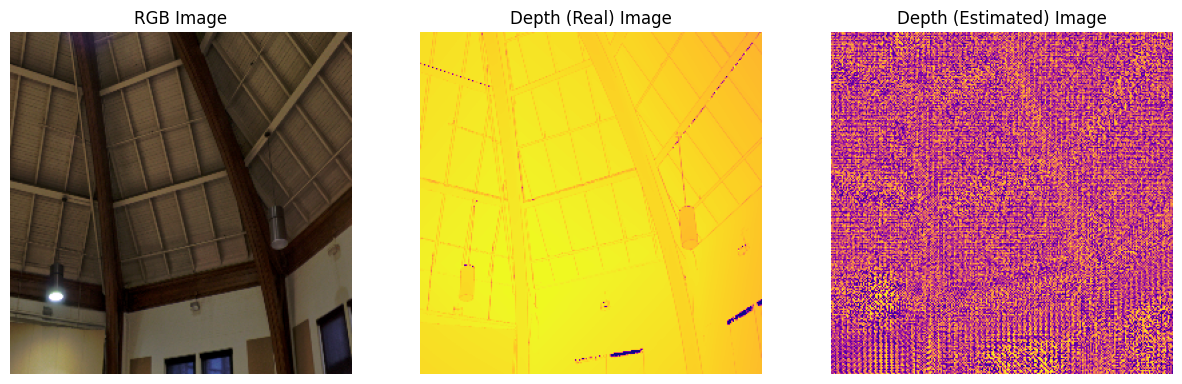

In [14]:
gen_images()

In [15]:
#@markdown ### Define Optimizers and Learning Rate Schedulers
optimizer_gen = optim.Adam(generator_params, learningRate, [beta1, beta2])
optimizer_disc_A = torch.optim.Adam(disc_A.parameters(),learningRate, [beta1,beta2])
optimizer_disc_B = torch.optim.Adam(disc_B.parameters(), learningRate, [beta1,beta2])

learningRate_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(optimizer_gen,lr_lambda = LambdaLR(num_epochs,decay_epoch).step)
learningRate_scheduler_disc_A = torch.optim.lr_scheduler.LambdaLR(optimizer_disc_A, lr_lambda = LambdaLR(num_epochs,decay_epoch).step)
learningRate_scheduler_disc_B = torch.optim.lr_scheduler.LambdaLR(optimizer_disc_B, lr_lambda = LambdaLR(num_epochs,decay_epoch).step)

In [16]:
#@markdown ### Define the training loop
def training_loop(dataloader, test_dataloader, n_epochs=1000):
    print_every = 10
    losses = []
    test_iter = iter(test_dataloader)
    fixed_RGB, fixed_Depth = next(test_iter)
    fixed_RGB = scale(fixed_RGB)
    fixed_Depth = scale(fixed_Depth)
    
    train_iter = iter(dataloader)
    batches_per_epoch = 1

    for epoch in range(1, n_epochs+1):
        if epoch % batches_per_epoch == 0:
            train_iter = iter(dataloader)

        images_RGB, images_Depth = next(train_iter)
        images_RGB = scale(images_RGB)
        images_Depth = scale(images_Depth)


        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_RGB = images_RGB.to(device)
        images_Depth = images_Depth.to(device)
#-------------------------------------Discriminator Training-----------------------------------------------------#

        # optimizers are initialized to zero so that they don't carry forward the errors form previous epochs. Basically to
        # to avoid any accumulation
        optimizer_disc_A.zero_grad()

        # Discriminator-A is initially checked for its performance with real image
        out_RGB = disc_A(images_RGB)
        disc_A_real_loss = real_mse_loss(out_RGB)

        # A fake image is generated by the generator to check the Discriminator's performance with fake image
        fake_RGB = gen_B2A(images_Depth)


        out_RGB = disc_A(fake_RGB)
        disc_A_fake_loss = fake_mse_loss(out_RGB)

        # Losses produced while the above operations are added which is the total loss of the Discriminator-A. It is backpropogated
        disc_A_loss = disc_A_real_loss + disc_A_fake_loss
        disc_A_loss.backward()
        optimizer_disc_A.step()

        # Same operations as mentioned above are now performed on Discriminator-B
        optimizer_disc_B.zero_grad()

        out_Depth = disc_B(images_Depth)
        disc_B_real_loss = real_mse_loss(out_Depth)

        fake_Depth = gen_A2B(images_RGB)

        out_Depth = disc_B(fake_Depth)
        disc_B_fake_loss = fake_mse_loss(out_Depth)


        disc_B_loss = disc_B_real_loss + disc_B_fake_loss
        disc_B_loss.backward()
        optimizer_disc_B.step()

#------------------------------------------Generator Training---------------------------------------------------#

        optimizer_gen.zero_grad()

        # An image is produced from the generator (in this case generator-B2A is being trained) is produced to check how well it can
        fake_RGB = gen_B2A(images_Depth)

        # The generated image is then fed to discrminator to check the fakeness and the MSE loss is received
        out_RGB = disc_A(fake_RGB)
        gen_B2A_loss = real_mse_loss(out_RGB)

        # To check the consistency, the generated image is fed to other generator(A2B in this case) and reconstructed image is received
        reconstructed_Depth = gen_A2B(fake_RGB)
        # Reconstruction loss is received by comparing two images as mentioned in step(4) of training generators
        reconstructed_Depth_loss = cycle_consistency_loss(images_Depth, reconstructed_Depth, lambda_weight=10)


        # Same operations are done, but this time to train gen_A2B
        fake_Depth = gen_A2B(images_RGB)


        out_Depth = disc_B(fake_Depth)
        gen_A2B_loss = real_mse_loss(out_Depth)


        reconstructed_RGB = gen_B2A(fake_Depth)
        reconstructed_RGB_loss = cycle_consistency_loss(images_RGB, reconstructed_RGB, lambda_weight=10)

        # Losses from both the generators are received and propogated backwards
        g_total_loss = gen_B2A_loss + gen_A2B_loss + reconstructed_Depth_loss + reconstructed_RGB_loss
        g_total_loss.backward()
        optimizer_gen.step()

        # Weight decay as mentioned earlier
        learningRate_scheduler_gen.step()
        learningRate_scheduler_disc_A.step()
        learningRate_scheduler_disc_B.step()



        if epoch % print_every == 0:

            losses.append((disc_A_loss.item(), disc_B_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, disc_A_loss.item(), disc_B_loss.item(), g_total_loss.item()))

        # A training sample is saved every given time to check the performance of our network
        sample_every=100

        if epoch % sample_every == 0:
            gen_B2A.eval()
            gen_A2B.eval()
            gen_B2A.train()
            gen_A2B.train()

        # Models are saved after every given number of epochs
        checkpoint_every=100
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, gen_A2B, gen_B2A, disc_A, disc_B)

    return losses

In [17]:
losses = training_loop(D, D, n_epochs=num_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3939 | d_Y_loss: 0.3523 | g_total_loss: 5.3408
Epoch [   20/ 5000] | d_X_loss: 0.1650 | d_Y_loss: 1.1651 | g_total_loss: 4.1636
Epoch [   30/ 5000] | d_X_loss: 0.1868 | d_Y_loss: 1.0294 | g_total_loss: 4.9225
Epoch [   40/ 5000] | d_X_loss: 0.4853 | d_Y_loss: 0.1524 | g_total_loss: 4.3577
Epoch [   50/ 5000] | d_X_loss: 0.3958 | d_Y_loss: 0.1757 | g_total_loss: 3.4837
Epoch [   60/ 5000] | d_X_loss: 0.8100 | d_Y_loss: 4.3561 | g_total_loss: 5.7030
Epoch [   70/ 5000] | d_X_loss: 0.3652 | d_Y_loss: 0.0529 | g_total_loss: 3.5339
Epoch [   80/ 5000] | d_X_loss: 0.5088 | d_Y_loss: 0.0275 | g_total_loss: 4.0742
Epoch [   90/ 5000] | d_X_loss: 0.2411 | d_Y_loss: 0.0605 | g_total_loss: 3.9547
Epoch [  100/ 5000] | d_X_loss: 1.0851 | d_Y_loss: 0.0487 | g_total_loss: 4.6066
Epoch [  110/ 5000] | d_X_loss: 0.2179 | d_Y_loss: 0.2270 | g_total_loss: 4.1585
Epoch [  120/ 5000] | d_X_loss: 0.4840 | d_Y_loss: 0.2089 | g_total_loss: 3.4080
Epoch [  130/ 5000] | d_X_lo

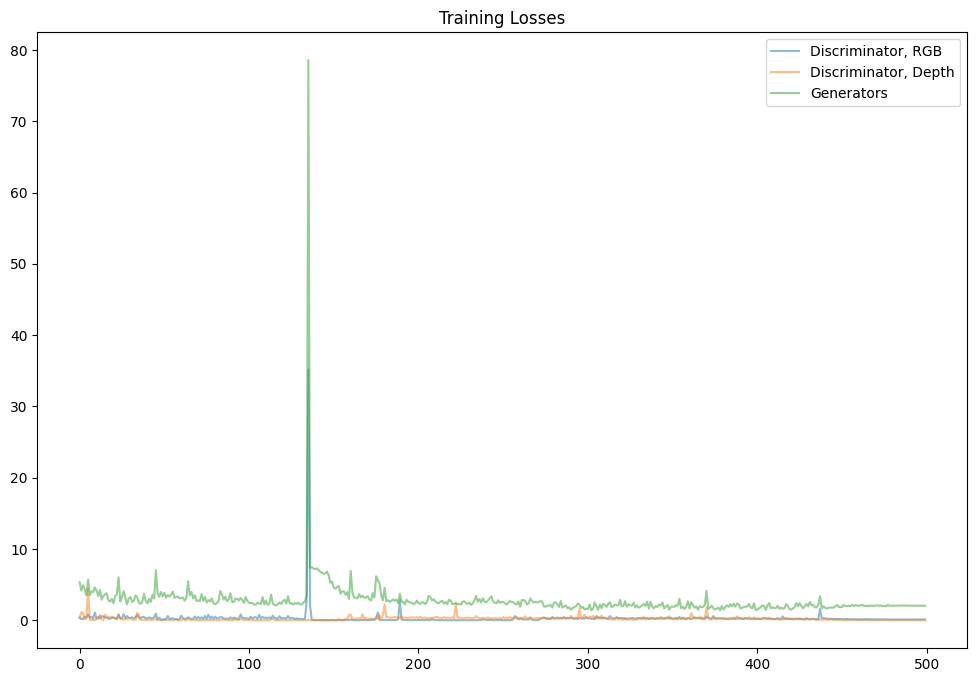

In [18]:
#@markdown ### Training losses
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, RGB', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Depth', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [19]:
def calculate_psnr():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    images = iter(D)
    
    psnrs = []
    for i in range(64):
        images_RGB, images_Depth = next(images)
        images_RGB, images_Depth = scale(images_RGB), scale(images_Depth)

        images_RGB = images_RGB.to(device)
        images_Depth = images_Depth.to(device)

        fake_Depth = gen_A2B(images_RGB)
        fake_Depth = fake_Depth.detach().cpu().numpy()
        images_RGB = images_RGB.cpu().numpy()
        images_Depth = images_Depth.cpu().numpy()
    
        psnr = cv2.PSNR(images_Depth, fake_Depth)
        psnrs.append(psnr)
    return np.mean(psnrs)

In [20]:
print("PSNR of 64 samples:", calculate_psnr())

PSNR of 64 samples: 58.51723896948195
